<a href="https://colab.research.google.com/github/IagoMagalhaes23/SAM_DinoV2/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SAM - Segment Anything

##Introdução

A segmentação — identificar quais pixels da imagem pertencem a um objeto — é uma tarefa central na visão computacional e é usada em uma ampla gama de aplicações, desde a análise de imagens científicas até a edição de fotos. Mas criar um modelo de segmentação preciso para tarefas específicas geralmente requer trabalho altamente especializado de especialistas técnicos com acesso à infraestrutura de treinamento de IA e grandes volumes de dados no domínio cuidadosamente anotados.

##Funcionamento

No processamento de linguagem natural e, mais recentemente, na visão computacional, um dos desenvolvimentos mais empolgantes é o dos modelos básicos que podem realizar aprendizado zero e poucos disparos para novos conjuntos de dados e tarefas usando técnicas de "prompting".

O SAM foi treinado para retornar uma máscara de segmentação válida para qualquer prompting, onde um prompt pode ser pontos de primeiro plano/fundo, uma caixa ou máscara aproximada, texto de forma livre ou, em geral, qualquer informação indicando o que segmentar em uma imagem. A exigência de uma máscara válida significa simplesmente que, mesmo quando um prompt é ambíguo e pode se referir a vários objetos (por exemplo, um ponto em uma camisa pode indicar a camisa ou a pessoa que a veste), a saída deve ser uma máscara razoável para um desses objetos. Essa tarefa é usada para pré-treinar o modelo e resolver tarefas gerais de segmentação downstream por meio de solicitação.

Foi observado que a tarefa de pré-treinamento e a coleta interativa de dados impuseram restrições específicas ao design do modelo. Em particular, o modelo precisa ser executado em tempo real em uma CPU em um navegador da Web para permitir que nossos anotadores usem o SAM interativamente em tempo real para anotar com eficiência. Embora a restrição de tempo de execução implique um compromisso entre qualidade e tempo de execução, descobrimos que um projeto simples produz bons resultados na prática.

Sob o capô, um codificador de imagem produz uma incorporação única para a imagem, enquanto um codificador leve converte qualquer solicitação em um vetor de incorporação em tempo real. Essas duas fontes de informação são combinadas em um decodificador leve que prevê máscaras de segmentação. Depois que a incorporação da imagem é calculada, o SAM pode produzir um segmento em apenas 50 milissegundos, a partir de qualquer solicitação em um navegador da web.


Texto retirado do site da Meta AI.

##Exemplo prático

###Segmentando uma imagem

In [3]:
import cv2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from google.colab import files
from google.colab.patches import cv2_imshow

import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wwr0jukm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wwr0jukm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=637167b2e360eda0fc5c44a9cb5ea7236a423af2d85bc5fd90a723fb6586cbce
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_ogwmnm/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

####Carregando imagem

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('Arquivo carregado com sucesso! \n "{name}" com tamanho de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving WIN_20230515_21_03_25_Pro.jpg to WIN_20230515_21_03_25_Pro.jpg
Arquivo carregado com sucesso! 
 "WIN_20230515_21_03_25_Pro.jpg" com tamanho de 125442 bytes


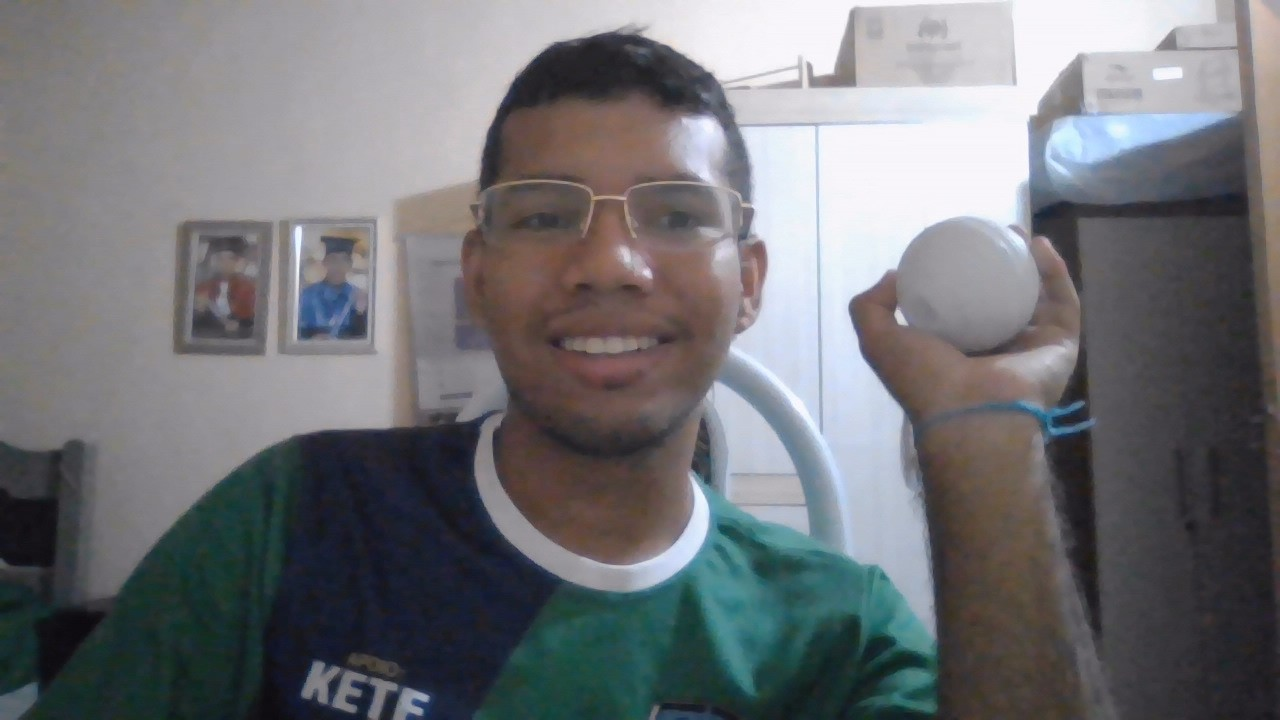

In [5]:
image = cv2.imread('WIN_20230515_21_03_25_Pro.jpg')
cv2_imshow(image)
cv2.waitKey(0)

cv2.destroyAllWindows()

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

####Automatic mask generation

A geração de máscara retorna uma lista de máscaras, onde cada máscara é um dicionário contendo vários dados sobre a máscara. Estas chaves são:
- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

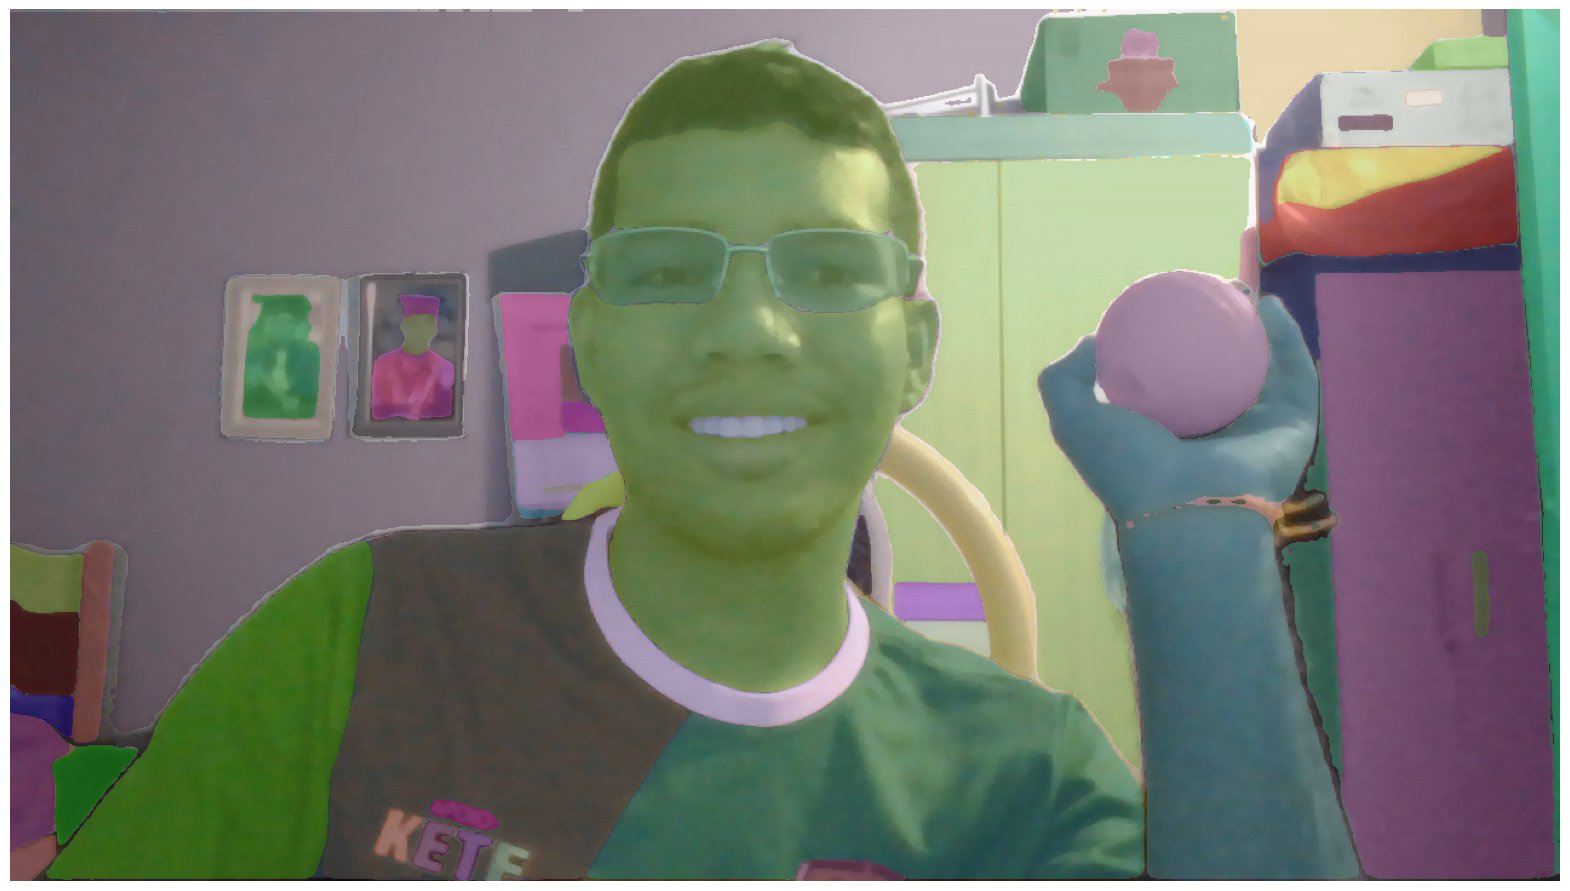

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [9]:
print(len(masks))
print(masks[0].keys())

79
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


##Referências
- https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/
- https://github.com/facebookresearch/segment-anything